In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import math
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
import matplotlib
from scipy.stats import ks_2samp, mannwhitneyu, wilcoxon

warnings.filterwarnings('ignore')
%matplotlib inline

Paths to raw files

In [2]:
raw_path = './../../data/Raw/suspicious_user'
derived_path = './../../data/Derived/suspicious_user'
suspended_status = 403

Concatinating all data from April 26 to May 25, 2021

In [3]:
df_all = pd.DataFrame(columns=['uid', 
                               'time', 
                               'acc_status', 
                               'tweet_count',
                              'deletion_count'])

for file in Path(raw_path).glob('*'):
    df = pd.read_pickle(file)
    df_all = df_all.append(df, ignore_index=True)
    
df_all['acc_status'] = pd.to_numeric(df_all['acc_status'])
df_all['tweet_count'] = pd.to_numeric(df_all['tweet_count'])
df_all['time'] = pd.to_datetime(df_all['time'], format='%Y-%m-%d')
print(df_all.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27444464 entries, 0 to 27444463
Data columns (total 5 columns):
 #   Column          Dtype         
---  ------          -----         
 0   uid             object        
 1   time            datetime64[ns]
 2   acc_status      int64         
 3   tweet_count     int64         
 4   deletion_count  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 1.0+ GB
None


In [4]:
df_all.to_pickle(f'{derived_path}/all_data.pkl.gz')

In [4]:
df_all = pd.read_pickle(f'{derived_path}/all_data.pkl.gz')

uid :&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; userid of twitter users <br>  time :&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; day API query was done <br>
acc_status : &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; status of account: 1 if active, 403 if suspended   <br>
tweet_count : &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; count of tweet in profile <br>
deletion_count : &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; number of deletions that happended on a day before query was made <br ><br >

For example: if the query was done on 2021-04-26, the deletion_count is the deletion that happened on day 2021-04-25

In [4]:
#Keeps only suspended days within active days
def filter_suspended_days_within_active(data, ascending=True):
    suspended_status = 403
    
    data['acc_status'] = data['acc_status'].astype(int)
    data = data.sort_values(by=['time'], ascending=ascending)
    data['cumsum'] = data.groupby('uid')['acc_status'].cumsum()
    data = data.loc[data['cumsum'] % suspended_status != 0]
    
    return data.drop(['cumsum'], axis=1)

#Removes single data points
def remove_single_data(data):
    data['count'] = data.groupby(
        ['uid']
    )['uid'].transform('count')
    data = data.loc[data['count'] != 1]

    return data.drop(['count'], axis=1)

In [154]:
#2D histogram
def hist2d(x, 
           y, 
           filename,
           x_label,
           y_label,
           title=None,
           base=10, 
           nbins=60, 
           colormap='Blues', 
           density=False
          ):
    fontsize = 26
    
    x_min = min([min(x), min(y)])
    x_max = max([max(x), max(y)])
    
    # Use non-equal bin sizes, such that they 
    #look equal on log scale.
    xbins = np.logspace(np.log10(x_min)/np.log10(base),
                        np.log10(x_max)/np.log10(base),
                        nbins, 
                        base = base
                       )
    
    histo, xedges, yedges = np.histogram2d(x,y,bins=(xbins,xbins), 
                                           density=False
                                          )
    dx = np.diff(xbins)
    print('Constant factor that multiplies width :', dx[1]/dx[0])
    
    area = dx[:, None] * dx
    l = histo.T/(area)
    
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    if title:
        ax.set_title(title,
                    fontsize=fontsize)
    
    pc = plt.pcolormesh(xbins,
                xbins,
                l, 
                cmap=colormap,
                norm=matplotlib.colors.LogNorm(
               ),
#                 label=f'{text} Deletion count per user'
              )
    ax.axline([10, 10], [20, 20], color='black', linewidth=0.2)
    
    ax.set_xlabel(x_label, fontsize=fontsize)
    ax.set_ylabel(y_label, fontsize=fontsize)
    
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    ax.set_xscale('log', base=base)
    ax.set_yscale('log', base=base)
   
    min_xbins = 10**(math.floor(min(xbins)/10))
    max_xbins = 10**(len(str(math.floor(max(xbins)))))
    
    ax.set_xlim([min_xbins, max_xbins])
    ax.set_ylim([min_xbins, max_xbins])
#     plt.xlim([min_xbins, max_xbins])
#     plt.ylim([min_xbins, max_xbins])
#     ax.format(suptitle = f'Estimated {text} deletion count Vs \n actual deletion count per user ',
#              xlabel='k')
    
    print(f'N ={x.shape[0]}, Bins={nbins}, Normalized (bin count / area of bin)')
    
    cbar = fig.colorbar(pc, ax=ax)
    cbar.ax.tick_params(labelsize=fontsize)
    
    fig.savefig(f'{filename}.png', 
          facecolor='white', 
          transparent=False)
    
    plt.show()

In [214]:
def ccdf(x, y, legend_1, legend_2, label, ax, filename=None, single=False, y_log=False, label_size=26, 
         z=None, z_label=None
        ):
    fontsize = 22
    
    if single and ax is None:
        fig, ax = plt.subplots(figsize=(9, 8))
        
    sns.ecdfplot(x, 
                 complementary=True,
                 label=legend_1,
                 color='blue',
                 ax=ax,
                linewidth=2,)
    sns.ecdfplot(y, 
                 complementary=True,
                 ax=ax,
                 label= legend_2,
                 color='red',
                linewidth=2,
                )
    if z is not None:
        sns.ecdfplot(z, 
             complementary=True,
             ax=ax,
             label= z_label,
             color='black',
            linewidth=2,
            )
    
    
#     if ax is None:
    ax.legend(loc="upper right", frameon=True, fontsize=label_size)
    ax.set_xscale('log')
    
    if y_log:
        ax.set_yscale('log')
        
    ax.set_xlabel(label, fontsize=fontsize)
    ax.set_ylabel('CCDF', fontsize=fontsize)
    ax.tick_params(axis='both', labelsize=fontsize)
    
    if z is not None:
        min_value = min(min(x), min(y), min(z))
        max_value = max(max(x), max(y), max(z))
    else: 
        min_value = min(min(x), min(y))
        max_value = max(max(x), max(y))
        
    min_tick = 10**(math.floor(min_value/10))
    max_tick = 10**(len(str(math.floor(max_value))))
    
    ax.set_xlim([min_tick, max_tick])
    ax.set_ylim(top= 1.1)
    ax.set_yticks([10**-6, 10**-4, 10**-2, 10**0]) 
    
    if ax is not None:
        return ax
    
    fig.savefig(f'{filename}.png', 
          facecolor='white', 
          transparent=False)

    plt.show()


In [9]:
#QQ plot for two sample
def qqplot_2sample(x, 
                   y, 
                   filename, 
                   xlabel, 
                   ylabel, 
                   marker='.', 
                   logscale=True):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    plt.scatter(np.sort(x), 
                np.sort(y),
                marker=marker
               )
    
    if logscale:
        plt.xscale('log')
        plt.yscale('log')
        
    ax.axline([10, 10], [20, 20], color='red')
    
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)

    fig.savefig(f'{filename}.png', 
              facecolor='white', 
              transparent=False)

https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test
<br >
c(alpha) for 0.05 significance level = 1.358 <br >
c(alpha) for 0.01 significance level = 1.628  <br >
D_c,alpha = c(alpha) * sqroot(1/n1 + 1/n2)  <br >

In [74]:
def statistics(x, y):
    D_c =  1.36*1/len(x)*2**0.5
    alpha = 0.05

    print('KS test')
    print('Two-sided: The null hypothesis is that the two distributionsn are identical,\n F(x)=G(x) for all x; the alternative is that they are not identical.')
    print('\n')
    print('Significance level 0.05 and 0.01') 
    print('D_c,0.05 = ',D_c)
    print('D_c,0.01 = ', 1.628*1/len(df_copy)*2**0.5)

    stat, p = ks_2samp(x, y)

    print('Statistics={}, p={}'.format(stat, p))

    if p > alpha:
        print('Same distribution (fail to reject H0)')
    else:
        print('Different distribution (reject H0)')

    print('\n\n')
    print('Mannwhitney U Test')

    stat, p = mannwhitneyu(x,y)

    print('Statistics={}, p={}'.format(stat, p))

    if p > alpha:
        print('Same distribution (fail to reject H0)')
    else:
        print('Different distribution (reject H0)')

    print('\n\n')
#     print('Wilcoxon Signed-Rank Test')

#     stat, p = wilcoxon(x, y)

#     print('Statistics={}, p={}'.format(stat, p))

#     if p > alpha:
#         print('Same distribution (fail to reject H0)')
#     else:
#         print('Different distribution (reject H0)')

Remove all data that appear one time and keep only data for active and suspended data in between active days

In [11]:
df = filter_suspended_days_within_active(df_all)
df = filter_suspended_days_within_active(df, False)
df = remove_single_data(df)

#########################################################################################################

## Model 1: Interpolating deletion data for suspended days
<br>

## Actual deletion count per day = $\Large  {D_{t}}$ <br>
${D_{t} = \text{Total Tweet Deletion on day t obtained from Compliance Firehose}}$


### Estimated deletion count on day  t = $\Large \frac{C_{t+\Delta t} - C_{t}}{\Delta t}$ <br>
${t = \text{day}}$ <br>
$C_{t} = \text{total tweet count on day t }$


In [12]:
df_copy = df.copy()

#estimate the deletion count for only active days
df_active = df_copy.loc[df_copy['acc_status'] == 1]
df_active = df_active.sort_values('time')
df_active['tweet_shift'] = df_active.groupby(['uid'])['tweet_count'].shift(
    periods=1)
df_active = df_active.sort_values('time')
df_active['time_shift'] = df_active.groupby(['uid'])['time'].shift(
    periods=1)
df_active['delay'] = (df_active['time'] - df_active['time_shift']).dt.days
df_active = df_active.loc[~df_active['delay'].isnull()]
df_test = df_active
df_test['estimated_deletion'] = (df_active['tweet_count'] - df_active['tweet_shift'])
df_active['estimated_deletion'] = (df_active['tweet_count'] - df_active['tweet_shift']) / df_active['delay']


#merge the deletion count data of active days with the suspended days
df_copy = df_copy.merge(df_active, on=['uid', 'time'], how='left')
df_copy = df_copy.drop(['acc_status_y', 
                        'tweet_count_y',
                        'deletion_count_y',
                       ], axis=1)

df_copy.rename(columns={'acc_status_x': 'acc_status',
                'tweet_count_x': 'tweet_count',
                'deletion_count_x': 'deletion_count'
               }, inplace=True)

#interpolate the deletion for suspended days
df_copy = df_copy.sort_values('time', ascending=False)
df_copy.loc[df_copy['estimated_deletion'].isnull(), 
            'estimated_deletion'] = 0
df_copy['estimated_shift'] = df_copy.groupby(['uid'])['estimated_deletion'].shift(
    periods=1)
df_copy['acc_shift'] = df_copy.groupby(['uid'])['acc_status'].shift(
    periods=1)
df_copy.loc[~((df_copy['acc_status'] == suspended_status) & (df_copy['acc_shift'] == 1)), 
            'estimated_shift']  = 0
df_copy['cumsum'] = 0
df_copy['cumsum'] = df_copy.groupby('uid')['estimated_shift'].cumsum()
df_copy.loc[df_copy['acc_status'] == suspended_status, 
            'estimated_deletion'] = df_copy['cumsum']
df_copy = df_copy.drop(['cumsum',
                        'estimated_shift',
                        'acc_shift'
                       ], axis=1)
df_copy = df_copy.loc[~((df_copy['acc_status'] == 1) & (df_copy['delay'].isnull()))]

df_copy = df_copy.sort_values('time')

#Filtering only deletions greater than 10
df_copy = df_copy.loc[df_copy['estimated_deletion'] <= -10]
df_copy['estimated_deletion'] = df_copy['estimated_deletion'] * -1

# #Median value for each user
df_copy['deletion_count'] = df_copy['deletion_count'].astype(float)
df_median = df_copy.groupby(['uid'])['estimated_deletion', 'deletion_count'].median()
df_median['deletion_count'] = df_median['deletion_count'].astype(float)

In [13]:
df_copy.loc[df_copy['uid'] == '1323399892899942402']

,uid,time,acc_status,tweet_count,deletion_count,tweet_shift,time_shift,delay,estimated_deletion
14562569,1323399892899942402,2021-05-05,1,41963,96.0,42043.0,2021-05-04,1.0,80.0
13602839,1323399892899942402,2021-05-06,1,41936,33.0,41963.0,2021-05-05,1.0,27.0
12852031,1323399892899942402,2021-05-07,1,41924,33.0,41936.0,2021-05-06,1.0,12.0


In [14]:
df_median.info()

<class 'pandas.core.frame.DataFrame'>
Index: 748202 entries, 1000000043833810945 to 999999473425289216
Data columns (total 2 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   estimated_deletion  748202 non-null  float64
 1   deletion_count      748202 non-null  float64
dtypes: float64(2)
memory usage: 17.1+ MB


In [15]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1299594 entries, 18748800 to 2
Data columns (total 9 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   uid                 1299594 non-null  object        
 1   time                1299594 non-null  datetime64[ns]
 2   acc_status          1299594 non-null  int64         
 3   tweet_count         1299594 non-null  int64         
 4   deletion_count      1299594 non-null  float64       
 5   tweet_shift         1299533 non-null  float64       
 6   time_shift          1299533 non-null  datetime64[ns]
 7   delay               1299533 non-null  float64       
 8   estimated_deletion  1299594 non-null  float64       
dtypes: datetime64[ns](2), float64(4), int64(2), object(1)
memory usage: 99.2+ MB


In [16]:
len(df_copy['uid'])

1299594

Constant factor that multiplies width : 1.1979317202421857
N =1299594, Bins=60, Normalized (bin count / area of bin)


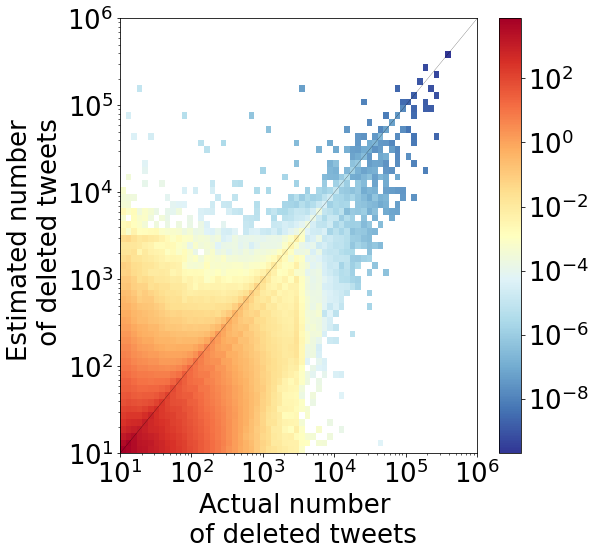

In [176]:
hist2d(df_copy['deletion_count'],
       df_copy['estimated_deletion'],
       filename='heatmap_interpolation_single',
       base=10,
      title=None,
      nbins=60,
       colormap='RdYlBu_r',
       x_label='Actual number \n of deleted tweets',
       y_label='Estimated number \n of deleted tweets'
      )

Constant factor that multiplies width : 1.1861305241249613
N =748202, Bins=60, Normalized (bin count / area of bin)


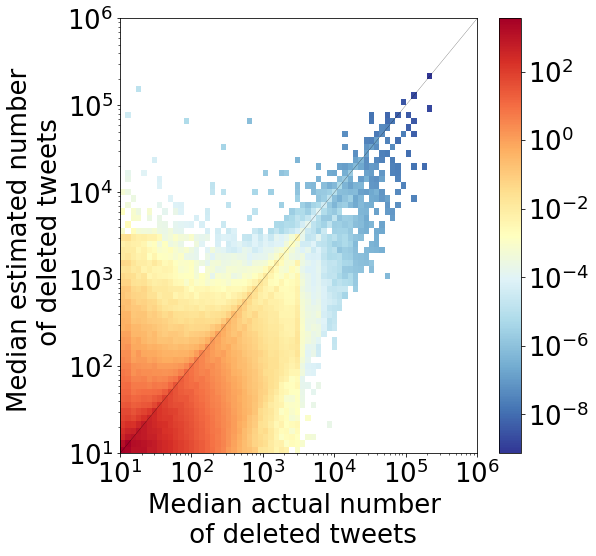

In [175]:
hist2d(df_median['deletion_count'],
       df_median['estimated_deletion'],
       filename='heatmap_interpolation_median_single',
       base=10,
      title=None,
      nbins=60,
       colormap='RdYlBu_r',
       x_label='Median actual number \n of deleted tweets',
       y_label='Median estimated number \n of deleted tweets'
      )

<AxesSubplot:xlabel='Number of deleted tweets', ylabel='CCDF'>

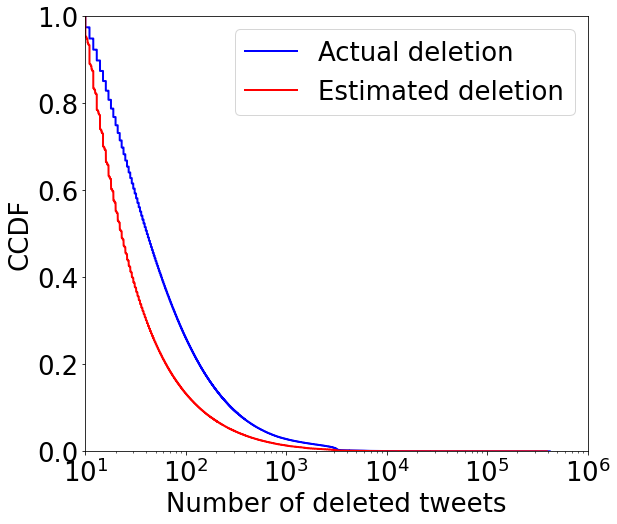

In [111]:
ccdf(df_copy['deletion_count'],
     df_copy['estimated_deletion'],
     'Actual deletion',
     'Estimated deletion',
     'Number of deleted tweets',
     ax=None,
     filename='ccdf_interpolation_single_test_1',
     single=True
    )

<AxesSubplot:xlabel='Median number of deleted tweets', ylabel='CCDF'>

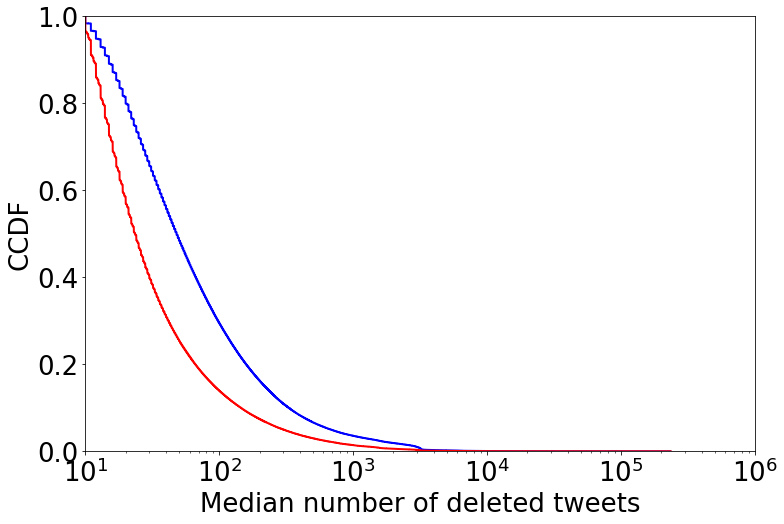

In [21]:
ccdf(df_median['deletion_count'],
     df_median['estimated_deletion'],
     'Actual',
     'Estimated',
     'Median number of deleted tweets',
     ax=None,
     filename='ccdf_interpolation_median_single',
     single=True
    )

In [22]:
max(df_copy['estimated_deletion'])

397159.0

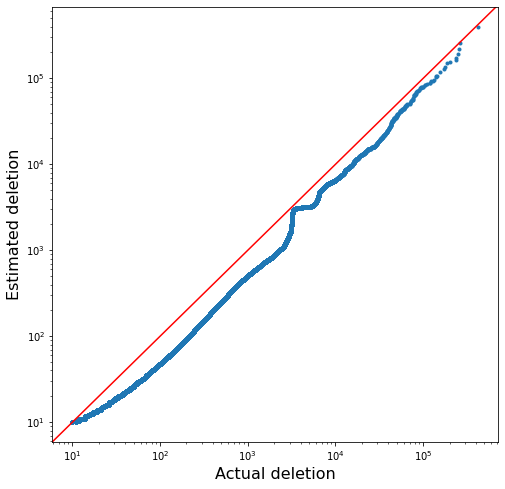

In [23]:
qqplot_2sample(df_copy['deletion_count'],
               df_copy['estimated_deletion'],
               'qq_interploation',
               'Actual deletion',
               'Estimated deletion'
              )
    

In our case D_c,0.05= 1.4798845263816688e-06 and D=0.21 and we reject the null hypothesis that both are drawn from the same distribution.

In [224]:
def hist_2d_subplot(x, y,
           x_label,
           y_label,
            ax,
           fig,
           title=None,
           base=10, 
           nbins=60, 
           colormap='RdYlBu_r', 
           density=False):
    fontsize = 22
    
    x_min = min([min(x), min(y)])
    x_max = max([max(x), max(y)])
    
    # Use non-equal bin sizes, such that they 
    #look equal on log scale.
    xbins = np.logspace(np.log10(x_min)/np.log10(base),
                        np.log10(x_max)/np.log10(base),
                        nbins, 
                        base = base
                       )
    
    histo, xedges, yedges = np.histogram2d(x,y,bins=(xbins,xbins), 
                                           density=False
                                          )
    dx = np.diff(xbins)
    
    print('Constant factor that multiplies width :', dx[1]/dx[0])
    
    area = dx[:, None] * dx
    l = histo.T/(area)
    
    if title:
        ax.set_title(title,
                    fontsize=fontsize)
    
    pc = ax.pcolormesh(xbins,
                xbins,
                l, 
                cmap=colormap,
                norm=matplotlib.colors.LogNorm(
               ),
#                 label=f'{text} Deletion count per user'
              )
    ax.axline([10, 10], [20, 20], color='black', linewidth=0.2)
    
    ax.set_xlabel(x_label, fontsize=fontsize)
    ax.set_ylabel(y_label, fontsize=fontsize)
    ax.minorticks_on()

    ax.tick_params(axis='both', labelsize=fontsize)
    
    ax.set_xscale('log', base=base)
    ax.set_yscale('log', base=base)
    
    min_xbins = 10**(math.floor(min(xbins)/10))
    max_xbins = 10**(len(str(math.floor(max(xbins)))))
    
    ax.set_xlim([min_xbins, max_xbins])
    ax.set_ylim([10**1, 10**6])
  
#     ax.set_yticks([10**1, 10**6, 0.01]) 
    
    print(f'N ={x.shape[0]}, Bins={nbins}, Normalized (bin count / area of bin)')
    
    cbar = fig.colorbar(pc, ax=ax)
    cbar.ax.tick_params(labelsize=fontsize)
    
   
    
    return ax
    

#Plots combined 2d histogram and CCDF
def all_figure(x, y,
#             x_median,
#             y_median,
           filename,
           x_label,
           y_label,
           title=None,
           base=10, 
           nbins=60, 
           colormap='RdYlBu_r', 
           density=False,
           ccdf_label1=None,
           ccdf_label2=None,
            z = None,
            z_label=None,
            y_log=False,
               label_size=16
              ):
    
    fontsize=20
    
    fig, ((ax1, ax2)) = plt.subplots(2,1, figsize=(11, 13))
    
    plt.subplots_adjust(right=0.9, top=0.93, bottom=0.07)
    
    fig.subplots_adjust(hspace=.4)
    
    
    #AX1
    ax1 = hist_2d_subplot(x, 
                    y,
                    x_label,
                    y_label,
                    ax=ax1,
                    fig=fig,
                    title=None,
                    base=10, 
                    nbins=nbins, 
                    colormap=colormap, 
                    density=False,
                    )
    
#     ax1.set_ylim([0, 1000000])
#     ax1.annotate('(a)', 
#                  xy=(0.0, 0.1),  
#                  xycoords='axes fraction',
#                  xytext=(0.0, 1.02), 
#                  textcoords='axes fraction', 
#                  fontsize=fontsize
#             )
    
                
    #AX2
    ax2 = ccdf(x,y,ccdf_label1,ccdf_label2,'Number of deleted tweets', ax=ax2, z=z, z_label=z_label, y_log=y_log, 
         label_size=label_size
        )

    fig.tight_layout(h_pad=3)
    ax2.set_ylim([0,1])
    fig.savefig(f'{filename}.png', 
          facecolor='white', 
          transparent=False)
    
    plt.show()



Constant factor that multiplies width : 1.1979317202421857
N =1299594, Bins=60, Normalized (bin count / area of bin)


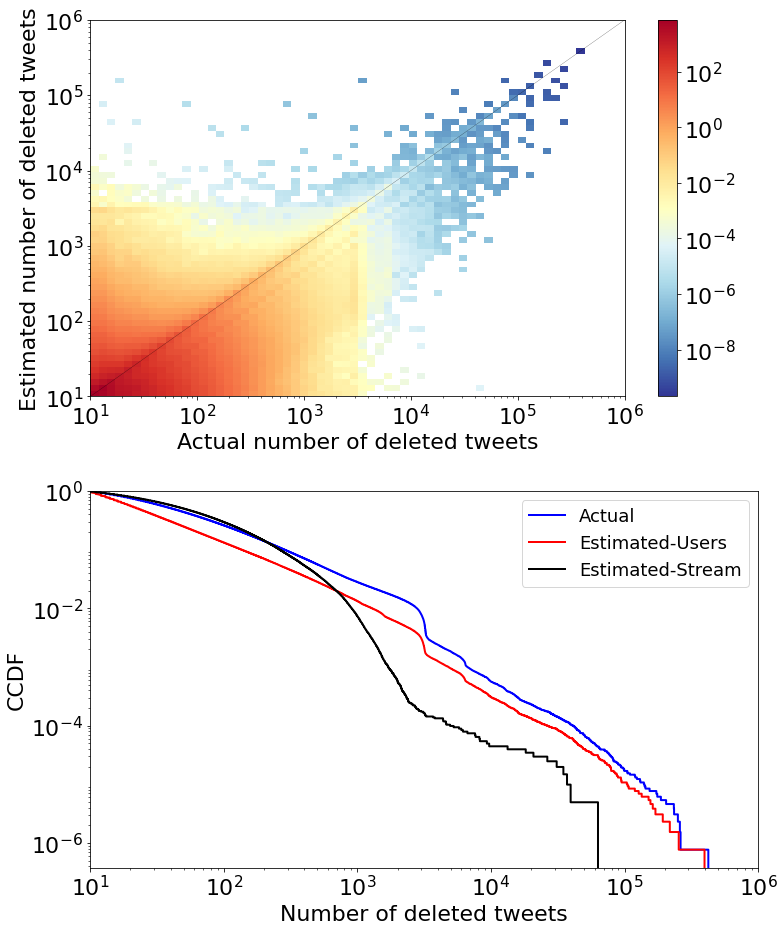

In [225]:
all_figure(df_copy['deletion_count'], 
           df_copy['estimated_deletion'], 
#            df_median['deletion_count'],
#            df_median['estimated_deletion'],
           filename='heatmap_interpolation_log_3_cdf',
           base=10,
           title=None,
           nbins=60,
           colormap='RdYlBu_r',
           x_label='Actual number of deleted tweets',
           y_label='Estimated number of deleted tweets',
           ccdf_label1='Actual',
           ccdf_label2='Estimated-Users',
           z=df_first_last['estimated_deletion']*-1,
           z_label='Estimated-Stream',
           y_log=True,
           label_size=18
          )

In [207]:
#########################################

Constant factor that multiplies width : 1.1979317202421857
N =1299594, Bins=60, Normalized (bin count / area of bin)


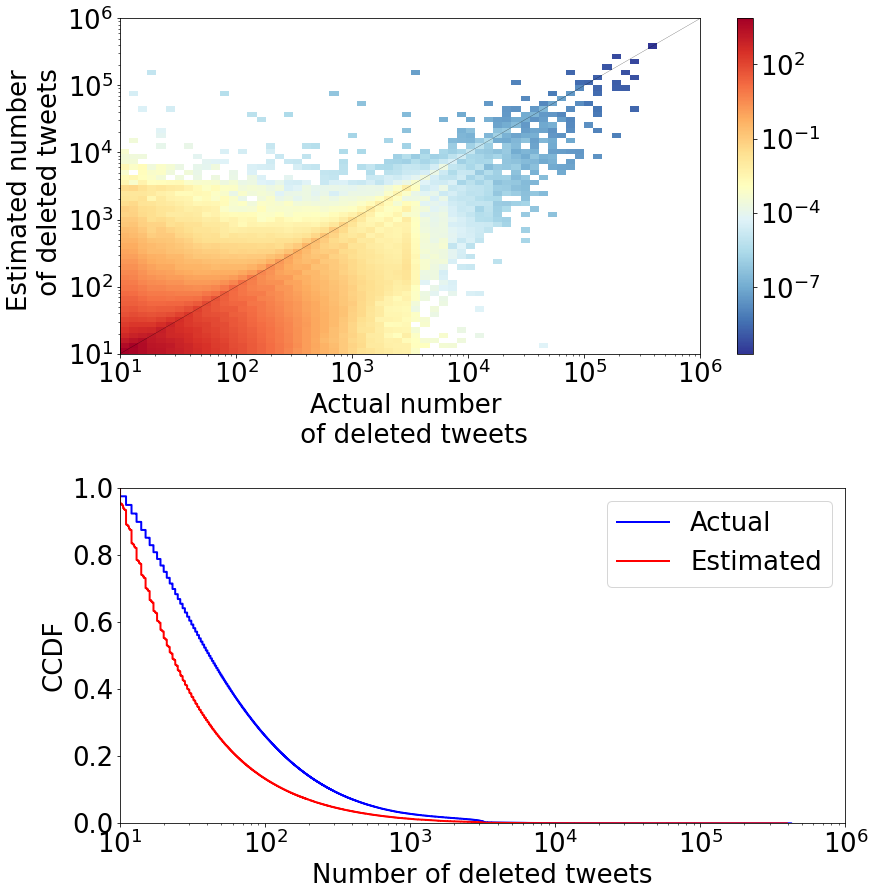

In [103]:
all_figure(df_copy['deletion_count'], 
           df_copy['estimated_deletion'], 
#            df_median['deletion_count'],
#            df_median['estimated_deletion'],
           filename='heatmap_interpolation',
           base=10,
           title=None,
           nbins=60,
           colormap='RdYlBu_r',
           x_label='Actual number \n of deleted tweets',
           y_label='Estimated number \n of deleted tweets',
           ccdf_label1='Actual',
           ccdf_label2='Estimated'
          )

In [28]:
statistics(df_copy['deletion_count'], df_copy['estimated_deletion'])
print('\n For median deletion count \n')
statistics(df_median['deletion_count'],
           df_median['estimated_deletion'],)

KS test
Two-sided: The null hypothesis is that the two distributionsn are identical,
 F(x)=G(x) for all x; the alternative is that they are not identical.


Significance level 0.05 and 0.01
D_c,0.05 =  1.4799471564407112e-06
D_c,0.01 =  1.7715838019746157e-06
Statistics=0.2174594527213884, p=0.0
Different distribution (reject H0)



Mannwhitney U Test
Statistics=604548263252.0, p=0.0
Different distribution (reject H0)



Wilcoxon Signed-Rank Test
Statistics=113607777630.0, p=0.0
Different distribution (reject H0)

 For median deletion count 

KS test
Two-sided: The null hypothesis is that the two distributionsn are identical,
 F(x)=G(x) for all x; the alternative is that they are not identical.


Significance level 0.05 and 0.01
D_c,0.05 =  2.5706031858073215e-06
D_c,0.01 =  1.7715838019746157e-06
Statistics=0.2610150734694641, p=0.0
Different distribution (reject H0)



Mannwhitney U Test
Statistics=185510439567.0, p=0.0
Different distribution (reject H0)



Wilcoxon Signed-Rank Test


In [29]:
#actual
df_copy['deletion_count'].mean()

170.82982300626196

In [30]:
#actual
df_copy['deletion_count'].median()

41.0

In [31]:
#estimated mean
df_copy['estimated_deletion'].mean()

93.99116007504355

In [32]:
#estimated median
df_copy['estimated_deletion'].median()


23.0

################### Comparison to Stream Data ######################

In [26]:
path = '/scratch/potem/'
new_file = 'stream_day1_parsed.pkl.gz'
save_path = '/scratch/potem/tweet-delete/'

In [27]:
df_stream = pd.read_pickle(f'{save_path}{new_file}')

In [28]:
df_stream.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3754644 entries, 0 to 3754643
Data columns (total 3 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   created_at   object
 1   id           object
 2   tweet_count  int64 
dtypes: int64(1), object(2)
memory usage: 85.9+ MB


In [29]:
df_stream['count'] = df_stream.groupby(
        ['id']
    )['id'].transform('count')

In [30]:
df_new = df_stream.loc[df_stream['count'] != 1].copy()

In [31]:
df_new = df_new.drop(['count'], axis=1)

In [32]:
df_new.head()

,created_at,id,tweet_count
0,2021-12-18T01:45:08.000Z,1226393005206061059,40006
1,2021-12-18T01:45:08.000Z,1226393005206061059,40006
2,2021-12-18T01:45:08.000Z,1172038122646822912,102168
3,2021-12-18T01:45:08.000Z,941022373,65166
4,2021-12-18T01:45:08.000Z,731313173542764544,74067


In [33]:
df_new = df_new.sort_values(by=['created_at'], ascending=True)

In [34]:
df_new['tweet_shift'] = df_new.groupby(['id'])['tweet_count'].shift(
    periods=1)

In [35]:
df_new = df_new.loc[~df_new['tweet_shift'].isnull()]

df_new['estimated_deletion'] = (df_new['tweet_count'] - df_new['tweet_shift'])

In [36]:
df_neagtive = df_new.loc[df_new['estimated_deletion'] < 0].copy()

In [37]:
df_neagtive = df_neagtive.loc[df_neagtive['estimated_deletion'] <= -10]

In [38]:
df_copy.loc[df_copy['uid'] == '1159169707947241474']

,uid,time,acc_status,tweet_count,deletion_count,tweet_shift,time_shift,delay,estimated_deletion
18748800,1159169707947241474,2021-04-28,1,15318,64.0,15355.0,2021-04-27,1.0,37.0
17732327,1159169707947241474,2021-04-29,1,15306,11.0,15318.0,2021-04-28,1.0,12.0
16189849,1159169707947241474,2021-05-02,1,15354,11.0,15365.0,2021-05-01,1.0,11.0
10978686,1159169707947241474,2021-05-10,1,15650,20.0,15667.0,2021-05-09,1.0,17.0


In [39]:
df_neagtive.head()

,created_at,id,tweet_count,tweet_shift,estimated_deletion
33699,2021-12-18T01:59:10.000Z,1460633156801888260,382,397.0,-15.0
55156,2021-12-18T02:08:52.000Z,1145953772952150016,77768161,77768177.0,-16.0
67696,2021-12-18T02:14:32.000Z,1451074925020680193,58847,58857.0,-10.0
69441,2021-12-18T02:15:19.000Z,1451074925020680193,58818,58841.0,-23.0
69477,2021-12-18T02:15:20.000Z,1438704120207130627,3768,3782.0,-14.0


In [40]:
df_neagtive.loc[df_neagtive['id'] == '1451074925020680193']

,created_at,id,tweet_count,tweet_shift,estimated_deletion
67696,2021-12-18T02:14:32.000Z,1451074925020680193,58847,58857.0,-10.0
69441,2021-12-18T02:15:19.000Z,1451074925020680193,58818,58841.0,-23.0
2248091,2021-12-18T15:36:37.000Z,1451074925020680193,59157,59174.0,-17.0


<AxesSubplot:xlabel='Number of deleted tweets', ylabel='CCDF'>

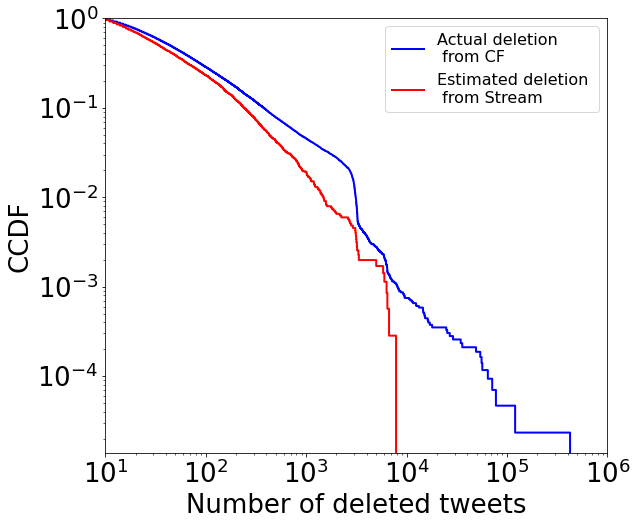

In [121]:
one_day_cf = df_copy.loc[df_copy['time'] == '2021-05-25']

ccdf(one_day_cf['deletion_count'],
     df_neagtive['estimated_deletion'] * -1,
     'Actual deletion \n from CF',
     'Estimated deletion \n from Stream',
     'Number of deleted tweets',
     ax=None,
     filename='ccdf_stream_single_5_25',
     single=True,
     y_log=True,
     label_size = 16
    )

In [83]:
print('One day stream mean :',df_neagtive['estimated_deletion'].mean() * -1)
print('One day stream median :',df_neagtive['estimated_deletion'].median() * -1)

One day stream mean : 123.67366628830874
One day stream median : 34.0


In [44]:
print('One day CF mean :',one_day_cf['deletion_count'].mean())
print('One day CF median :',one_day_cf['deletion_count'].median())

One day CF mean : 124.28299559471365
One day CF median : 34.0


In [46]:
print('One day stream max :',df_neagtive['estimated_deletion'].max() * -1)
print('One day stream min :',df_neagtive['estimated_deletion'].min() * -1)

One day stream max : 10.0
One day stream min : 7853.0


In [45]:
print('One day CF mean :',one_day_cf['deletion_count'].max())
print('One day CF median :',one_day_cf['deletion_count'].min())

One day CF mean : 154095.0
One day CF median : 10.0


In [75]:
statistics(one_day_cf['deletion_count'], df_neagtive['estimated_deletion'])

KS test
Two-sided: The null hypothesis is that the two distributionsn are identical,
 F(x)=G(x) for all x; the alternative is that they are not identical.


Significance level 0.05 and 0.01
D_c,0.05 =  3.437280752081868e-05
D_c,0.01 =  1.7715838019746157e-06
Statistics=1.0, p=0.0
Different distribution (reject H0)



Mannwhitney U Test
Statistics=0.0, p=0.0
Different distribution (reject H0)





################# Taking into consideration only first and last tweet ##################

In [47]:
df_first_last = df_stream.loc[df_stream['count'] != 1].copy()
df_first_last = df_first_last.drop(['count'], axis=1)

g = df_first_last.groupby('id')

df_first_last = (pd.concat([g.head(1), g.tail(1)])
#    .drop_duplicates()
   .sort_values('id')
   .reset_index(drop=True))

In [48]:
df_first_last.head()

,created_at,id,tweet_count
0,2021-12-18T15:39:54.000Z,1000004525011361792,11583
1,2021-12-18T16:48:55.000Z,1000004525011361792,11590
2,2021-12-18T15:17:26.000Z,1000007576,9233
3,2021-12-18T21:46:15.000Z,1000007576,9235
4,2021-12-18T23:43:48.000Z,1000010990069649409,508


In [49]:
df_first_last['tweet_shift'] = df_first_last.groupby(['id'])['tweet_count'].shift(
    periods=1)
df_first_last = df_first_last.loc[~df_first_last['tweet_shift'].isnull()]

df_first_last['estimated_deletion'] = (df_first_last['tweet_count'] - df_first_last['tweet_shift'])
df_first_last = df_first_last.loc[df_first_last['estimated_deletion'] < 0]
df_first_last = df_first_last.loc[df_first_last['estimated_deletion'] <= -10]

In [50]:
df_first_last.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202026 entries, 11 to 1064269
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   created_at          202026 non-null  object 
 1   id                  202026 non-null  object 
 2   tweet_count         202026 non-null  int64  
 3   tweet_shift         202026 non-null  float64
 4   estimated_deletion  202026 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 9.2+ MB


In [51]:
len(df_first_last['id'].unique())

202026

In [119]:
df_copy['time'].unique()

array(['2021-04-28T00:00:00.000000000', '2021-04-29T00:00:00.000000000',
       '2021-04-30T00:00:00.000000000', '2021-05-01T00:00:00.000000000',
       '2021-05-02T00:00:00.000000000', '2021-05-03T00:00:00.000000000',
       '2021-05-04T00:00:00.000000000', '2021-05-05T00:00:00.000000000',
       '2021-05-06T00:00:00.000000000', '2021-05-07T00:00:00.000000000',
       '2021-05-08T00:00:00.000000000', '2021-05-09T00:00:00.000000000',
       '2021-05-10T00:00:00.000000000', '2021-05-11T00:00:00.000000000',
       '2021-05-12T00:00:00.000000000', '2021-05-13T00:00:00.000000000',
       '2021-05-14T00:00:00.000000000', '2021-05-15T00:00:00.000000000',
       '2021-05-16T00:00:00.000000000', '2021-05-17T00:00:00.000000000',
       '2021-05-18T00:00:00.000000000', '2021-05-19T00:00:00.000000000',
       '2021-05-20T00:00:00.000000000', '2021-05-21T00:00:00.000000000',
       '2021-05-22T00:00:00.000000000', '2021-05-23T00:00:00.000000000',
       '2021-05-24T00:00:00.000000000', '2021-05-25

<AxesSubplot:xlabel='Number of deleted tweets', ylabel='CCDF'>

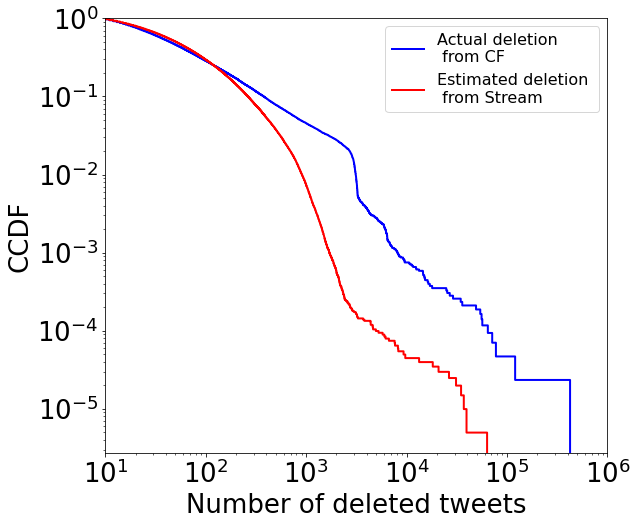

In [122]:
one_day_cf = df_copy.loc[df_copy['time'] == '2021-05-25']

ccdf(one_day_cf['deletion_count'],
     df_first_last['estimated_deletion'] * -1,
     'Actual deletion \n from CF',
     'Estimated deletion \n from Stream',
     'Number of deleted tweets',
     ax=None,
     filename='ccdf_first_last_single_5_25',
     single=True,
     y_log=True,
     label_size = 16
    )

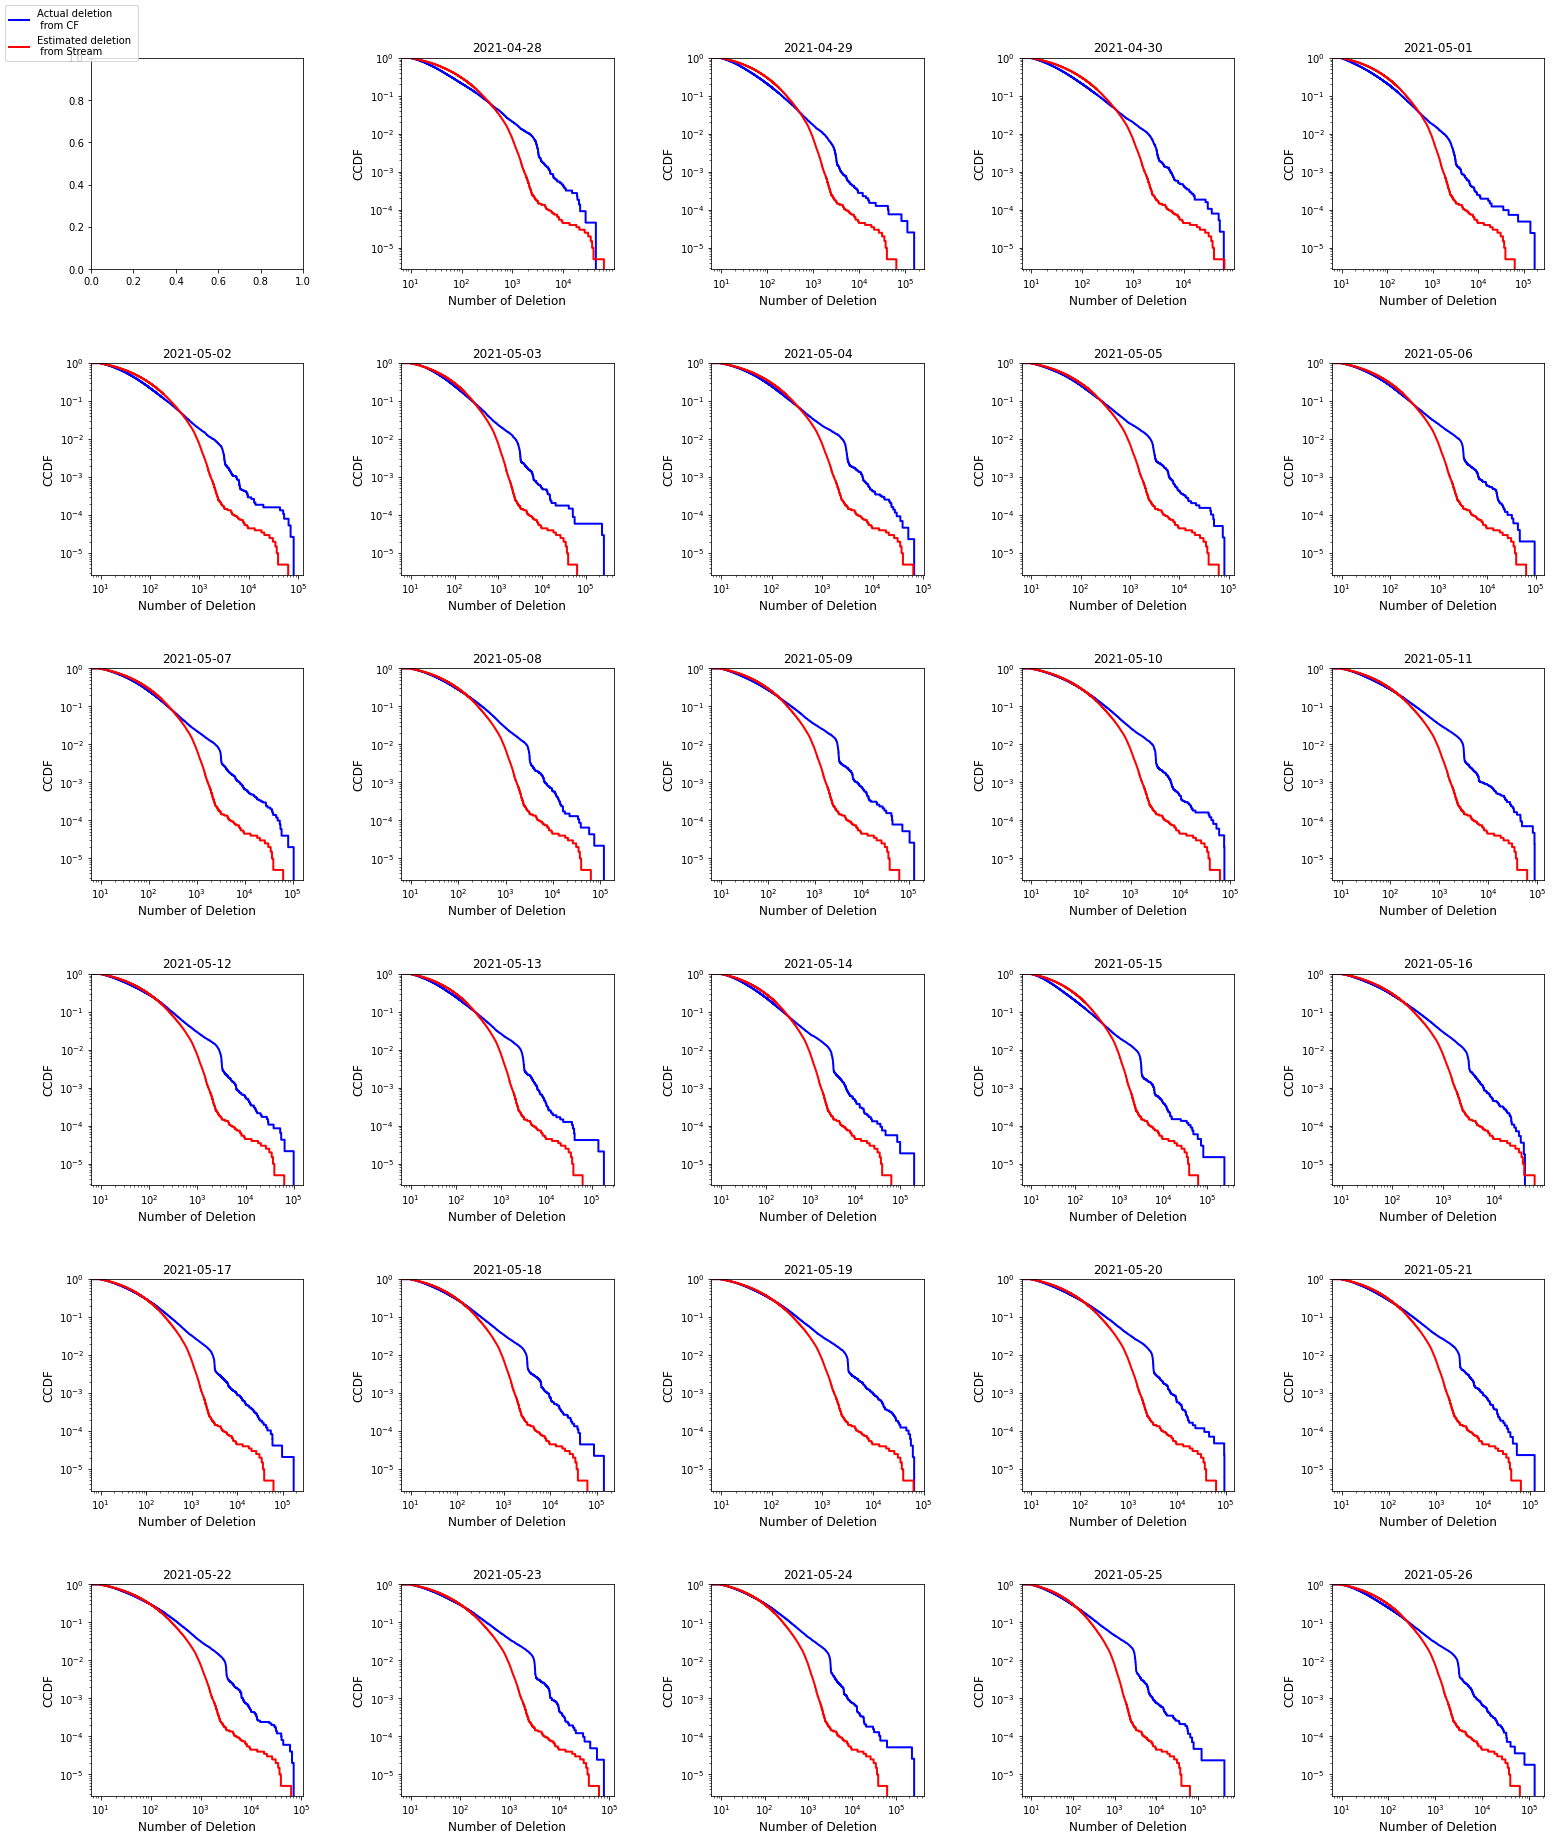

In [76]:
fig, ax = plt.subplots(6, 5, figsize=(22, 26))
j = 0
k = 0
dates = list(df_copy['time'].dt.strftime('%Y-%m-%d').unique())
# print(dates)
for i, day in enumerate(dates):
    
    if j == 4:
        j = 0
        k = k + 1
    else:
        j = j+ 1

    one_day_cf = df_copy.loc[df_copy['time'] == day]
   
    ax[k, j].set_title(day)
    sns.ecdfplot(one_day_cf['deletion_count'], 
                 complementary=True,
                 label='Actual deletion \n from CF',
                 color='blue',
                 ax=ax[k, j],
                linewidth=2,)
    sns.ecdfplot(df_first_last['estimated_deletion'] * -1, 
                 complementary=True,
                 ax=ax[k, j],
                 label= 'Estimated deletion \n from Stream',
                 color='red',
                linewidth=2,
                )
    ax[k, j].set_xscale('log')
    
    
    ax[k, j].set_yscale('log')
        
    ax[k, j].set_xlabel('Number of Deletion', fontsize=12)
    ax[k, j].set_ylabel('CCDF', fontsize=12)
#     ax[k, j].tick_params(axis='both', labelsize=12)
    handles, labels = ax[k, j].get_legend_handles_labels()
    
        
fig.tight_layout(pad=4.0)
fig.legend(handles, labels, loc='upper left')
fig.savefig('all_days_ccdf.png', 
          facecolor='white', 
          transparent=False)
    
plt.show()


################ Statistics ########################

In [226]:
one_day_cf = df_copy.loc[df_copy['time'] == '2021-05-25']

stream_mean = df_first_last['estimated_deletion'].mean() * -1
stream_median = df_first_last['estimated_deletion'].median() * -1

CF_mean = df_copy['deletion_count'].mean()
CF_median = df_copy['deletion_count'].median()

stream_max = df_first_last['estimated_deletion'].min() * -1
stream_min = df_first_last['estimated_deletion'].max() * -1

CF_max = df_copy['deletion_count'].max()
CF_min = df_copy['deletion_count'].min()

print('One day stream mean :', stream_mean)
print('One day stream median :', stream_median)

print('All day CF mean :', CF_mean)
print('All day CF median :', CF_median)

print('One day stream max :', stream_max)
print('One day stream min :', stream_min)

print('All day CF max :', CF_max)
print('All day CF min :', CF_min)

print('\n % error in median \n \n ')
print((CF_median - stream_median) / CF_median * 100)

print('\n % error in mean \n \n ')
print((CF_mean - stream_mean) / CF_mean * 100)

One day stream mean : 113.41037292229713
One day stream median : 51.0
All day CF mean : 170.82982300626196
All day CF median : 41.0
One day stream max : 63303.0
One day stream min : 10.0
All day CF max : 424123.0
All day CF min : 10.0

 % error in median 
 
 
-24.390243902439025

 % error in mean 
 
 
33.61207608454881


###### Three cdfs together ######

Constant factor that multiplies width : 1.1979317202421857
N =1299594, Bins=60, Normalized (bin count / area of bin)


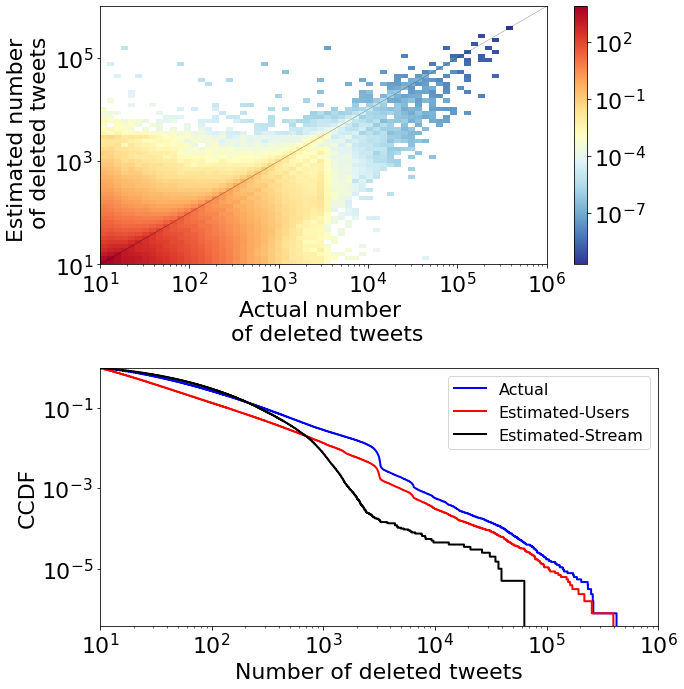

In [157]:
all_figure(df_copy['deletion_count'], 
           df_copy['estimated_deletion'], 
#            df_median['deletion_count'],
#            df_median['estimated_deletion'],
           filename='heatmap_interpolation_log_3_cdf',
           base=10,
           title=None,
           nbins=60,
           colormap='RdYlBu_r',
           x_label='Actual number \n of deleted tweets',
           y_label='Estimated number \n of deleted tweets',
           ccdf_label1='Actual',
           ccdf_label2='Estimated-Users',
           z=df_first_last['estimated_deletion']*-1,
           z_label='Estimated-Stream',
           y_log=True,
           label_size=16
          )

In [ ]:
#Ticks starting from 10^0, 
#labels (Estimated-Users, Estimated-Stream) , 
#color to black, 
#second last or last day for plot of stream,
#recalculate mean based on day

In [90]:
# df_copy.groupby(['time'])['deletion_count'].describe()['max'] > (df_first_last['estimated_deletion'].max()*-1)
    #.loc[['count','mean', 'median','max', 'min']]

####################################### End #############################

In [24]:
#Errors

## Model 2: No interpolation (Only active and consecutive days)

## Estimated deletion count on day  t = $\Large C_{t+1} - C_{t} $
<br>

$C_{t} = \text{total tweet count on day t }$
<br >

## Actual deletion count per day = $\Large  {D_{t}}$ <br>
${D_{t} = \text{Total Tweet Deletion on day t obtained from Compliance Firehose}}$


In [25]:
df_active = df.copy()
df_active = df_active.loc[df_active['acc_status'] == 1]
df_active = df_active.sort_values('time')
df_active['time_shift'] = df_active.groupby(['uid'])['time'].shift(
    periods=1)
df_active['tweet_shift'] = df_active.groupby(['uid'])['tweet_count'].shift(
    periods=1)
df_active['delay'] = (df_active['time'] - df_active['time_shift']).dt.days

df_active['estimated_deletion'] = df_active['tweet_count'] - df_active['tweet_shift']

#Keep only data with time difference of 1 day
df_active = df_active.loc[df_active['delay'] == 1]

#Filter the estimated deletion less than 10
df_active = df_active.loc[df_active['estimated_deletion'] <= -10]
df_active['estimated_deletion'] = df_active['estimated_deletion'] * -1
df_active['deletion_count'] = df_active['deletion_count'].astype(float)

#Median
df_active_median = df_active.groupby('uid')['estimated_deletion', 'deletion_count'].median()

In [26]:
df_active.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 837916 entries, 1321765 to 26736279
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   uid                 837916 non-null  object        
 1   time                837916 non-null  datetime64[ns]
 2   acc_status          837916 non-null  int64         
 3   tweet_count         837916 non-null  int64         
 4   deletion_count      837916 non-null  float64       
 5   time_shift          837916 non-null  datetime64[ns]
 6   tweet_shift         837916 non-null  float64       
 7   delay               837916 non-null  float64       
 8   estimated_deletion  837916 non-null  float64       
dtypes: datetime64[ns](2), float64(4), int64(2), object(1)
memory usage: 63.9+ MB


In [27]:
df_active_median.head()

,estimated_deletion,deletion_count
uid,,
1000000043833810945,15.0,19.0
1000003806141140993,33.0,74.0
1000004424989753344,13.0,12.5
1000005409170571265,53.0,28.0
1000005776,44.0,35.0


Constant factor that multiplies width : 1.1979317202421857
N =837916, Bins=60, Normalized (bin count / area of bin)


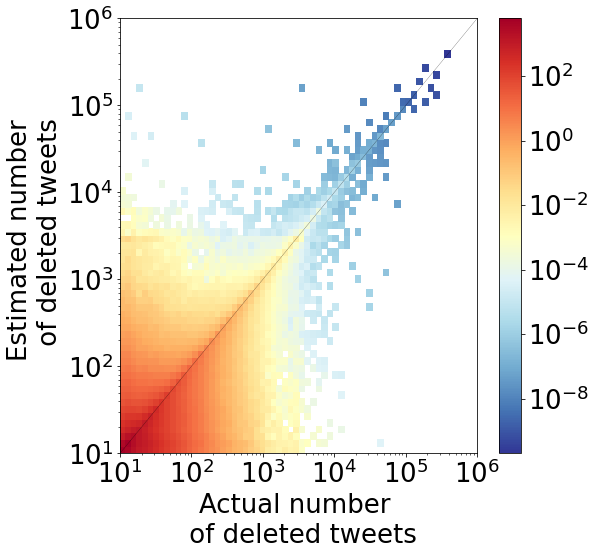

In [43]:
hist2d(df_active['deletion_count'],
       df_active['estimated_deletion'],
       filename='heatmap_no_interpolation_single',
       base=10,
       title=None,
       nbins=60,
       colormap='RdYlBu_r',
       x_label='Actual number \n of deleted tweets',
       y_label='Estimated number \n of deleted tweets'
      )

Constant factor that multiplies width : 1.1880139222045627
N =479702, Bins=60, Normalized (bin count / area of bin)


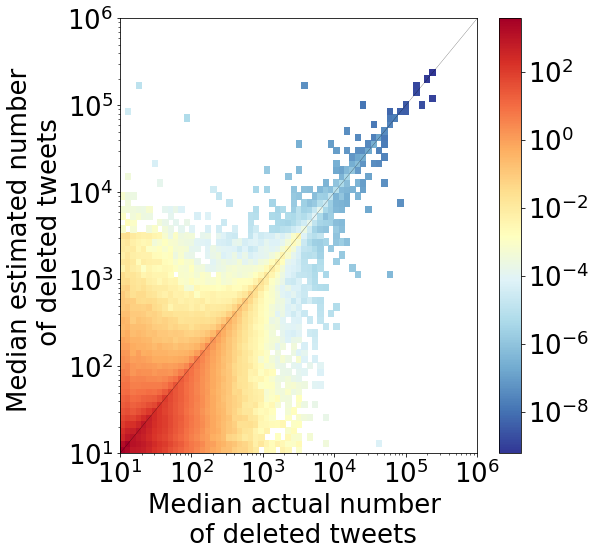

In [44]:
hist2d(df_active_median['deletion_count'],
       df_active_median['estimated_deletion'],
       filename='heatmap_no_interpolation_median_single',
       base=10,
       title=None,
       nbins=60,
       colormap='RdYlBu_r',
       x_label='Median actual number \n of deleted tweets',
       y_label='Median estimated number \n of deleted tweets'
      )

<AxesSubplot:xlabel='Number of deleted tweets', ylabel='CCDF'>

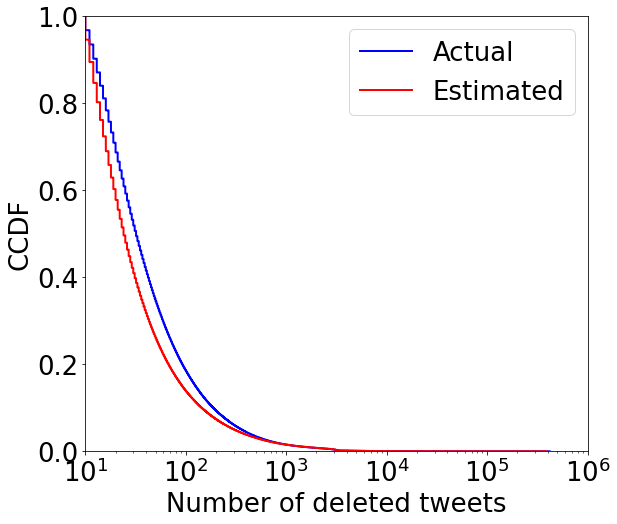

In [30]:
ccdf(df_active['deletion_count'],
     df_active['estimated_deletion'],
     'Actual',
     'Estimated',
     'Number of deleted tweets',
     ax=None,
     filename='ccdf_no_interpolation_single',
     single=True
    )

<AxesSubplot:xlabel='Median number of deleted tweets', ylabel='CCDF'>

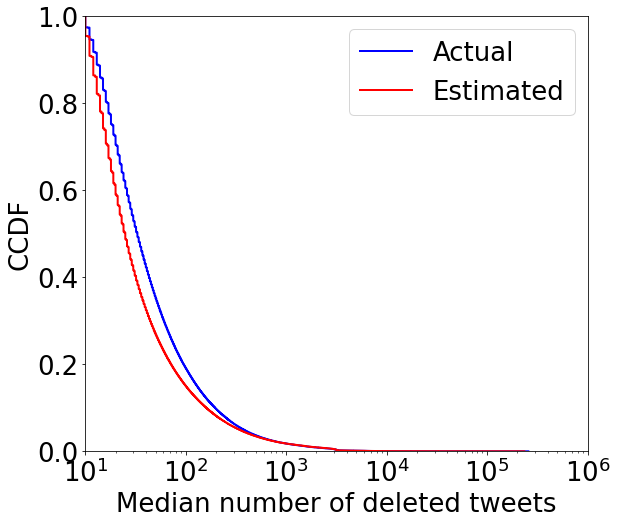

In [31]:
ccdf(df_active_median['deletion_count'],
     df_active_median['estimated_deletion'],
     'Actual',
     'Estimated',
     'Median number of deleted tweets',
     ax=None,
     filename='ccdf_no_interpolation_median_single',
     single=True
    )

Constant factor that multiplies width : 1.1979317202421857
N =837916, Bins=60, Normalized (bin count / area of bin)


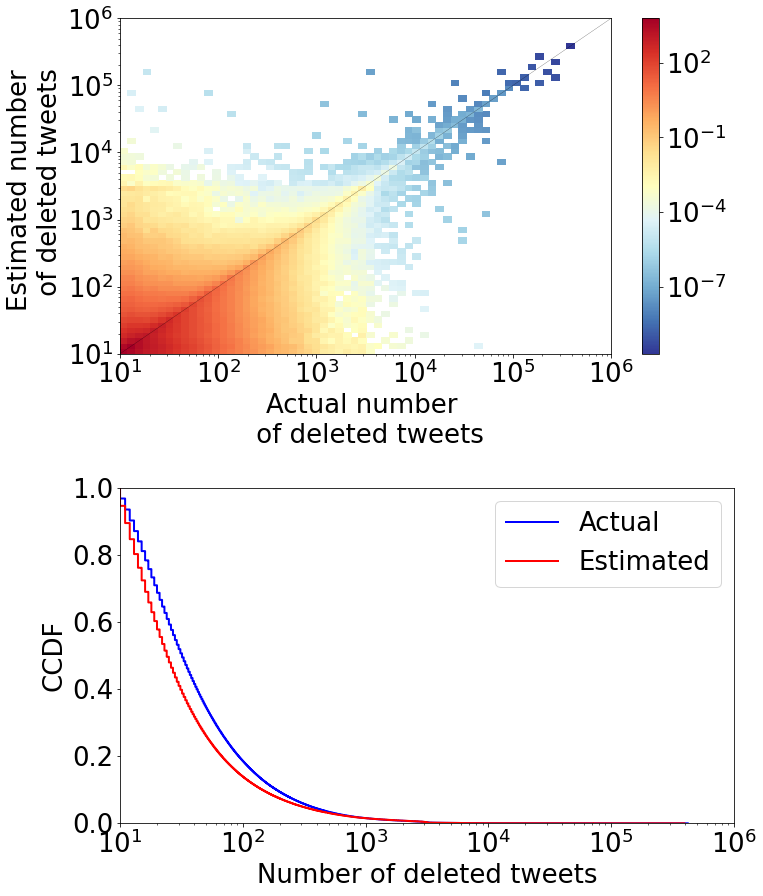

In [45]:
all_figure(df_active['deletion_count'], 
           df_active['estimated_deletion'], 
           df_active_median['deletion_count'],
           df_active_median['estimated_deletion'],
           filename='heatmap_no_interpolation',
           base=10,
           title=None,
           nbins=60,
           colormap='RdYlBu_r',
           x_label='Actual number \n of deleted tweets',
           y_label='Estimated number \n of deleted tweets',
           ccdf_label1='Actual',
           ccdf_label2='Estimated'
          )

In [33]:
statistics(df_active['deletion_count'], df_active['estimated_deletion'])
print('\n For median deletion count \n')
statistics(df_active_median['deletion_count'],
           df_active_median['estimated_deletion'],)

KS test
Two-sided: The null hypothesis is that the two distributionsn are identical,
 F(x)=G(x) for all x; the alternative is that they are not identical.


Significance level 0.05 and 0.01
D_c,0.05 =  2.295373814114314e-06
D_c,0.01 =  1.7715838019746157e-06
Statistics=0.11289317783644182, p=0.0
Different distribution (reject H0)



Mannwhitney U Test
Statistics=300186559033.5, p=0.0
Different distribution (reject H0)



Wilcoxon Signed-Rank Test
Statistics=76184353035.0, p=0.0
Different distribution (reject H0)

 For median deletion count 

KS test
Two-sided: The null hypothesis is that the two distributionsn are identical,
 F(x)=G(x) for all x; the alternative is that they are not identical.


Significance level 0.05 and 0.01
D_c,0.05 =  4.009427613033528e-06
D_c,0.01 =  1.7715838019746157e-06
Statistics=0.1184506214274696, p=0.0
Different distribution (reject H0)



Mannwhitney U Test
Statistics=98157127566.0, p=0.0
Different distribution (reject H0)



Wilcoxon Signed-Rank Test
Sta

### Model 3: Only active days

### Estimated deletion count on day  t = $\Large \frac{C_{t+\Delta t} - C_{t}}{\Delta t}$ <br>
${t = \text{day}}$ <br>
$C_{t} = \text{total tweet count on day t }$

### Actual deletion count per day = $\Large {D_t} $

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19352652 entries, 27435300 to 19187
Data columns (total 5 columns):
 #   Column          Dtype         
---  ------          -----         
 0   uid             object        
 1   time            datetime64[ns]
 2   acc_status      int64         
 3   tweet_count     int64         
 4   deletion_count  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 885.9+ MB


In [35]:
df_sus = df.copy()

df_sus['deletion_count'] = df_sus['deletion_count'].astype(float)
df_sus = df_sus.loc[df_sus['acc_status'] == 1]

df_sus['time_shift'] = df_sus.groupby(['uid'])['time'].shift(
    periods=1)
df_sus['delay'] = (df_sus['time'] - df_sus['time_shift']).dt.days

df_sus['tweet_shift'] = df_sus.groupby(['uid'])['tweet_count'].shift(
    periods=1)
df_sus = df_sus.loc[~df_sus['delay'].isnull()]


df_sus['estimated_deletion'] = (df_sus['tweet_count'] - df_sus['tweet_shift']) / df_sus['delay']

df_sus = df_sus.loc[df_sus['estimated_deletion'] <= -10]
df_sus = df_sus.loc[df_sus['deletion_count'] >= 10]
df_sus['estimated_deletion'] = df_sus['estimated_deletion'] * -1

df_sus_median = df_sus.groupby('uid')['estimated_deletion', 'deletion_count'].median()

In [36]:
df_sus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1299533 entries, 26440141 to 19230
Data columns (total 9 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   uid                 1299533 non-null  object        
 1   time                1299533 non-null  datetime64[ns]
 2   acc_status          1299533 non-null  int64         
 3   tweet_count         1299533 non-null  int64         
 4   deletion_count      1299533 non-null  float64       
 5   time_shift          1299533 non-null  datetime64[ns]
 6   delay               1299533 non-null  float64       
 7   tweet_shift         1299533 non-null  float64       
 8   estimated_deletion  1299533 non-null  float64       
dtypes: datetime64[ns](2), float64(4), int64(2), object(1)
memory usage: 99.1+ MB


In [37]:
df_sus.loc[df_sus['uid'] == '1323399892899942402']

,uid,time,acc_status,tweet_count,deletion_count,time_shift,delay,tweet_shift,estimated_deletion
8178545,1323399892899942402,2021-05-06,1,41936,33.0,2021-05-07,-1.0,41924.0,12.0
6904202,1323399892899942402,2021-05-05,1,41963,96.0,2021-05-06,-1.0,41936.0,27.0
6084317,1323399892899942402,2021-05-04,1,42043,128.0,2021-05-05,-1.0,41963.0,80.0


Constant factor that multiplies width : 1.3119647433305002
N =1299533, Bins=40, Normalized (bin count / area of bin)


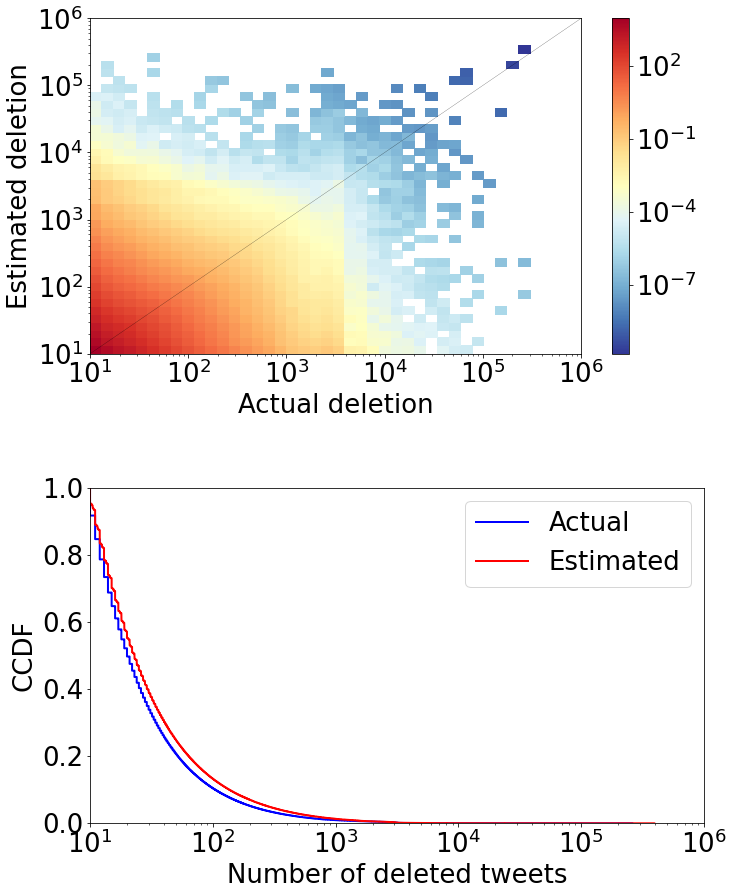

In [38]:
all_figure(df_sus['deletion_count'], 
           df_sus['estimated_deletion'], 
           df_sus_median['deletion_count'],
           df_sus_median['estimated_deletion'],
           filename='heatmap_sus',
           base=10,
           title=None,
           nbins=40,
           colormap='RdYlBu_r',
           x_label='Actual deletion',
           y_label='Estimated deletion',
           ccdf_label1='Actual',
           ccdf_label2='Estimated'
          )

In [39]:
statistics(df_sus['deletion_count'], df_sus['estimated_deletion'],)
print('\n For median deletion count \n')
statistics(df_sus_median['deletion_count'],
           df_sus_median['estimated_deletion'],)

KS test
Two-sided: The null hypothesis is that the two distributionsn are identical,
 F(x)=G(x) for all x; the alternative is that they are not identical.


Significance level 0.05 and 0.01
D_c,0.05 =  1.480016625070244e-06
D_c,0.01 =  1.7715838019746157e-06
Statistics=0.05558612209155134, p=0.0
Different distribution (reject H0)



Mannwhitney U Test
Statistics=777733950377.5, p=0.0
Different distribution (reject H0)



Wilcoxon Signed-Rank Test
Statistics=368952872650.0, p=0.0
Different distribution (reject H0)

 For median deletion count 

KS test
Two-sided: The null hypothesis is that the two distributionsn are identical,
 F(x)=G(x) for all x; the alternative is that they are not identical.


Significance level 0.05 and 0.01
D_c,0.05 =  2.5706031858073215e-06
D_c,0.01 =  1.7715838019746157e-06
Statistics=0.10234401939583154, p=0.0
Different distribution (reject H0)



Mannwhitney U Test
Statistics=239366682310.5, p=0.0
Different distribution (reject H0)



Wilcoxon Signed-Rank Test

In [40]:
texts = ['Interpolation in suspended days',
         'Median, Interpolation in suspended days ',
         'Ignoring deletion data in suspended days',
         'Median, Ignoring deletion data in suspended days',
         'Using deletion data in suspended days',
         'Median, Using deletion data in suspended days'
        ]
def calculate_error(data):
    i = 0
    
    print('Mean Percentage Error')
    print('sum((actual - estimated)/actual) / number of samples * 100 \n')
    print('Mean difference ')
    print('mean of actual - mean of estimated \n')
    
    for x in data:
        col = 'deletion_count'
        if 'actual_deletion' in x.columns:
            col = 'actual_deletion'
        error = np.sum((x[col] - x['estimated_deletion'])/x[col]) * 100/ len(x)
        print(texts[i] + ' : ' + str(round(error,2)) +'%')
        print('Mean Difference :', 
              str(np.mean(x[col]) - np.mean(x['estimated_deletion'])) + ' \n')
        i = i + 1
    

calculate_error([df_copy, 
                 df_median,
                 df_active, 
                 df_active_median,
                 df_sus,
                 df_sus_median
                ])

Mean Percentage Error
sum((actual - estimated)/actual) / number of samples * 100 

Mean difference 
mean of actual - mean of estimated 

Interpolation in suspended days : -1.97%
Mean Difference : 76.83866293121841 

Median, Interpolation in suspended days  : 7.78%
Mean Difference : 100.07236510815801 

Ignoring deletion data in suspended days : -22.74%
Mean Difference : 12.542925543849265 

Median, Ignoring deletion data in suspended days : -20.87%
Mean Difference : 10.542395070272804 

Using deletion data in suspended days : -283.34%
Mean Difference : -17.877346980836677 

Median, Using deletion data in suspended days : -319.33%
Mean Difference : -28.326838293646304 

